# Используемые модули

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


# Описание набора данных

В качестве набора данных используется предобработанный датасет [vxheavens](https://archive.org/download/vxheavens-2010-05-18), содержащий информацию о некоторых характеристиках вредоносного (и не очень) ПО.

Предобработка заключается в следующем:

1. Отобраны вирусы только для платформы Win32.
2. Для каждого файла извлечены секции PE хедеров: стандартная секция COFF и опциональный хедер, подсекции стандартная и Windows (без data directories).
3. Данные из файлов с неполной информацией (извлечение всех хедеров невозможно) не попали в представленную выборку.
4. В полученном файле по порядку идут поля хедеров. Последний столбец <code>class</code> отвечает за класс вредоносного ПО.

С дополнительной информацией по PE можно ознакомиться [тут](https://docs.microsoft.com/en-us/windows/win32/debug/pe-format) и [тут](https://en.wikipedia.org/wiki/Portable_Executable).

# Разведочный анализ данных

Считайте набор данных в датафрейм.

In [4]:
df = pd.read_csv('sources/virus_data.csv')
df

,Machine,NumberOfSections,TimeDateStamp,PointerToSymbolTable,NumberOfSymbols,SizeOfOptionalHeader,Characteristics,Magic,MajorLinkerVersion,MinorLinkerVersion,...,CheckSum,Subsystem,DllCharacteristics,SizeOfStackReserve,SizeOfStackCommit,SizeOfHeapReserve,SizeOfHeapCommit,LoaderFlags,NumberOfRvaAndSizes,class
0,332,3,56,0,0,224,271,267,6,0,...,0,2,0,1048576,4096,1048576,4096,0,16,Trojan-GameThief
1,332,4,1174051863,0,0,224,271,267,5,12,...,7495,2,0,1048576,4096,1048576,4096,0,16,Trojan-PSW
2,332,4,1173537981,0,0,224,271,267,5,12,...,54025,2,0,1048576,4096,1048576,4096,0,16,Trojan-PSW
3,332,4,1159472992,0,0,224,271,267,5,12,...,17862,2,0,1048576,4096,1048576,4096,0,16,Trojan-PSW
4,332,1,0,0,0,224,271,267,2,50,...,31382,2,0,1048576,4096,1048576,4096,0,16,Trojan-PSW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235871,332,3,1228822611,0,0,224,8462,267,6,0,...,0,2,0,1048576,4096,1048576,4096,0,16,Trojan-GameThief
235872,332,3,708992601,0,0,224,33167,267,2,25,...,0,2,0,1048576,16384,1048576,4096,0,16,Trojan-GameThief
235873,332,3,1228822731,0,0,224,8462,267,6,0,...,0,2,0,1048576,4096,1048576,4096,0,16,Trojan-GameThief
235874,332,3,1228823067,0,0,224,8462,267,6,0,...,0,2,0,1048576,4096,1048576,4096,0,16,Trojan-GameThief


Определите сбалансированность датасета. Постройте столбчатую диаграмму распределения представителей всех классов набора данных. Определите какое количество экземпляров класса <code>Trojan-PSW</code> содержится в наборе данных.

,Machine,NumberOfSections,TimeDateStamp,PointerToSymbolTable,NumberOfSymbols,SizeOfOptionalHeader,Characteristics,Magic,MajorLinkerVersion,MinorLinkerVersion,...,CheckSum,Subsystem,DllCharacteristics,SizeOfStackReserve,SizeOfStackCommit,SizeOfHeapReserve,SizeOfHeapCommit,LoaderFlags,NumberOfRvaAndSizes,class
1,332,4,1174051863,0,0,224,271,267,5,12,...,7495,2,0,1048576,4096,1048576,4096,0,16,Trojan-PSW
2,332,4,1173537981,0,0,224,271,267,5,12,...,54025,2,0,1048576,4096,1048576,4096,0,16,Trojan-PSW
3,332,4,1159472992,0,0,224,271,267,5,12,...,17862,2,0,1048576,4096,1048576,4096,0,16,Trojan-PSW
4,332,1,0,0,0,224,271,267,2,50,...,31382,2,0,1048576,4096,1048576,4096,0,16,Trojan-PSW
5,332,4,1173541965,0,0,224,271,267,5,12,...,31081,2,0,1048576,4096,1048576,4096,0,16,Trojan-PSW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235859,332,3,708992537,0,0,224,41358,267,2,25,...,0,2,1,0,0,1048576,4096,0,16,Trojan-PSW
235860,332,3,708992537,0,0,224,41358,267,2,25,...,0,2,1,0,0,1048576,4096,0,16,Trojan-PSW
235861,332,4,1192206223,0,0,224,8462,267,6,0,...,0,2,0,1048576,4096,1048576,4096,0,16,Trojan-PSW
235862,332,2,4096,8,0,224,8462,267,0,58,...,0,2,0,1048576,4096,1048576,4096,0,16,Trojan-PSW


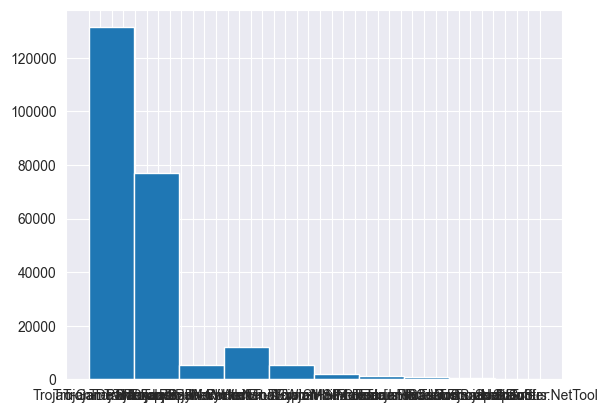

In [11]:
df['class'].hist()
df['class'].value_counts(normalize=True)

df.loc[df['class'] == "Trojan-PSW"]

Очевидно, датасет очень сильно несбалансирован. Имеет смысл построить классификатор, который не будет пытаться распознать все возможные угрозы, а будет сконцентрирован на самых популярных.

Вычислите долю представителей каждого класса относительно всего набора данных. Отсортируйте метки классов по убыванию доли представленности. Определите минимальное количество самых обильно представленных классов и сами эти классы так, чтобы суммарная доля их представленности была строго больше <code>0.8</code>. Введите полученное число классов.

In [15]:
# Подсчет количества представителей каждого класса
class_counts = df['class'].value_counts()

# Вычисление доли для каждого класса
class_ratios = class_counts / len(df)

# Сортировка классов по убыванию доли
sorted_class_ratios = class_ratios.sort_values(ascending=False)
print(sorted_class_ratios)

cumulative_ratio = sorted_class_ratios.cumsum()

num_classes = np.where(cumulative_ratio > 0.8)[0][0] + 1
selected_classes = sorted_class_ratios.index[:num_classes]

print(f'Количество классов: {num_classes}')
print(f'Классы: {selected_classes.tolist()}')


class
Backdoor               0.215049
Trojan                 0.182342
Trojan-Downloader      0.180849
Trojan-GameThief       0.122764
Trojan-PSW             0.071287
Trojan-Spy             0.048411
Trojan-Dropper         0.033357
Trojan-Banker          0.029592
Worm                   0.024479
Rootkit                0.013477
Email-Worm             0.011769
Trojan-Clicker         0.010972
Virus                  0.010849
Trojan-Proxy           0.008666
Net-Worm               0.007924
Hoax                   0.004710
HackTool               0.002980
Exploit                0.002692
Constructor            0.002573
P2P-Worm               0.002238
Packed                 0.001552
IM-Worm                0.001514
not-virus:Hoax         0.001348
Trojan-Mailfinder      0.001255
VirTool                0.001255
DoS                    0.000899
Flooder                0.000797
Email-Flooder          0.000759
IRC-Worm               0.000683
Trojan-IM              0.000572
IM-Flooder             0.000564
Tr

Из исходного набора данных не меняя порядок следования объектов отберите только представителей отобранных на предыдущем этапе классов. Полученную выборку будем называть **рабочей**. Определите объем рабочей выборки.

In [16]:
working_set = df[df['class'].isin(selected_classes)]

# Определение объема рабочей выборки
working_set_size = len(working_set)
print(f'Объем рабочей выборки: {working_set_size}')

Объем рабочей выборки: 193584


# Построение моделей

В качестве первого приближения имеет смысл построить модель классификации без каких-либо манипуляций с данными.

При помощи <code>train_test_split()</code> разбейте рабочую выборку на обучающую и тестовую части <b>с параметрами, указанными в вашем задании</b>. Используйте стратификацию по колонке <code>class</code>.

Обучите модель <code>DecisionTreeClassifier()</code> с параметрами указанными в вашем задании на тренировочных данных. Вычислите <code>accuracy_score</code> модели на тестовых данных.

In [18]:
X = working_set.drop(columns=['class'])
y = working_set['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5, stratify=y)

model = DecisionTreeClassifier(random_state=5)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.3f}')

Accuracy: 0.7533


Используя поле <code>feature_importances_</code> определите самый важный признак с точки зрения модели и значение его важности. Отберите признаки для которых значение важности строго больше <code>0.01</code>. Определите число полученных признаков.

In [20]:
feature_importances = model.feature_importances_
most_important_feature_index = feature_importances.argmax()
most_important_feature_name = X.columns[most_important_feature_index]
most_important_feature_value = feature_importances[most_important_feature_index]

print(f'Самый важный признак: {most_important_feature_name}')
print(f'Значение важности: {most_important_feature_value:.3f}')
important_features_mask = feature_importances > 0.01
important_features = X.columns[important_features_mask]

# Количество полученных признаков
num_important_features = len(important_features)
print(f'Количество признаков с важностью > 0.01: {num_important_features}')

Самый важный признак: AddressOfEntryPoint
Значение важности: 0.1556
Количество признаков с важностью > 0.01: 17


Из рабочей выборки отберите только самые важные признаки, которые были получены на предыдущем этапе, так, чтобы порядок колонок определялся важностью признаков (по убыванию). Далее аналогично предыдущему случаю: разделение, обучение, оценка.

In [21]:
X_important = X[important_features]
sorted_indices = feature_importances[important_features_mask].argsort()[::-1]
X_important_sorted = X_important.iloc[:, sorted_indices]

X_train, X_test, y_train, y_test = train_test_split(X_important_sorted, y, test_size=0.2, random_state=5, stratify=y)

model_dt_final = DecisionTreeClassifier(random_state=5)
model_dt_final.fit(X_train, y_train)

y_pred_dt = model_dt_final.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f'Accuracy DecisionTreeClassifier: {accuracy_dt:.3f}')

Accuracy DecisionTreeClassifier: 0.7506


Видно, что качество модели не сильно изменилось. При этом количество признаков уменьшилось значительно.

Можно попытаться улучшить результаты, использовав ансамбль моделей.

Используя тренировочную и тестовую выборки, полученные на предыдущем этапе, обучите модель <code>RandomForestClassifier()</code> с параметрами указанными в вашем задании на тренировочных данных. Вычислите <code>accuracy_score</code> модели на тестовых данных.

In [22]:
model_rf = RandomForestClassifier(random_state=5)
model_rf.fit(X_train, y_train)

y_pred_rf = model_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Accuracy RandomForestClassifier: {accuracy_rf:.3f}')

Accuracy RandomForestClassifier: 0.7961
